<a href="https://colab.research.google.com/github/NesquikPlz/Conditional_VAE_for_celebA/blob/main/implement_Conditional_VAE_for_celebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Conditional Variational Auto Encoder for CelebA Dataset
<br>
* This code is based on : <br>
CVAE >> https://www.kaggle.com/nadergo/conditional-vae-on-faces
<br>
Load Image >> https://colab.research.google.com/drive/1E9SS-QwdXwsjNoAXJ_ea4if2sTksq3LZ?usp=sharing#scrollTo=HkxBensPj8sd


###1. Package Installation

In [1]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install natsort==7.1.0 Pillow==8.0.1 gdown

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
import random
import torch

In [3]:
#fix the random seed absolutely
manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [4]:
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

device

device(type='cpu')

##2. Load Data

In [5]:
from torchvision import transforms, datasets

In [6]:
import os
import zipfile

import gdown

from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image

In [7]:
"""Download the CelebA Dataset_Image"""

# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with individual images
img_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url_picture = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(img_folder)

# Download the dataset from google drive
gdown.download(url_picture, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(img_folder)


Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:13<00:00, 109MB/s]


In [17]:
"""Download the CelebA Dataset_Attribute"""

# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with individual images
img_folder = f'{data_root}/list_attr_celeba'
# URL for the CelebA dataset
url_attr = 'https://drive.google.com/u/0/uc?id=15YnF4M6U6vA2ggPHNHWRERTsEs3S2s84'
# Path to download the dataset to
download_path = f'{img_folder}/list_attr_celeba.csv'
# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(img_folder)

# Download the dataset from google drive
gdown.download(url_attr, download_path, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=15YnF4M6U6vA2ggPHNHWRERTsEs3S2s84&export=download
To: /content/data/celeba/list_attr_celeba.csv

  0%|          | 0.00/26.7M [00:00<?, ?B/s]
 18%|█▊        | 4.72M/26.7M [00:00<00:00, 39.5MB/s]
100%|██████████| 26.7M/26.7M [00:00<00:00, 105MB/s]


'data/celeba/list_attr_celeba.csv'

In [8]:
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

In [9]:
# Spatial size of training images, images are resized to this size.
image_size = 64
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(f'{img_folder}/img_align_celeba', transform)

In [10]:
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

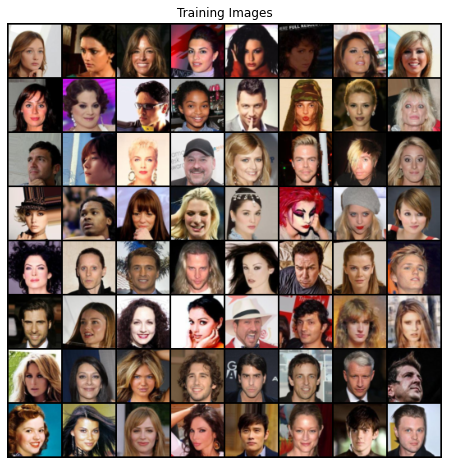

In [13]:
real_batch = next(iter(celeba_dataloader))
image_grid = vutils.make_grid(real_batch.to(device)[:64],
                              padding=2,
                              normalize=True).cpu()
image_grid = np.transpose(image_grid, (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(image_grid)